Nikan Lahut

In [37]:
from pandas import read_csv as csv
from pandas import to_datetime

df = csv('taxi-trips.xls')

In [38]:
df.pickup_datetime=to_datetime(df.pickup_datetime)
df.dropoff_datetime=to_datetime(df.dropoff_datetime)


Reverse Geocoding using  reverse_geocoder package


In [39]:
from reverse_geocoder import search
x1 = df.pickup_latitude.tolist()
y1 = df.pickup_longitude.tolist()
x2 = df.dropoff_latitude.tolist()
y2 = df.dropoff_longitude.tolist()

p_points = []
d_points = []
for i in range(len(df)):
    p_points.append((x1[i],y1[i]))
for i in range(len(df)):
    d_points.append((x2[i],y2[i]))

p = search(p_points)
d = search(d_points)

pname = [i['name'] for i in p]
dname = [i['name'] for i in d]

df['pickup_district'] = pname
df['dropoff_district'] = dname

Common locations are calculated using Counter class, plotted using pyplot

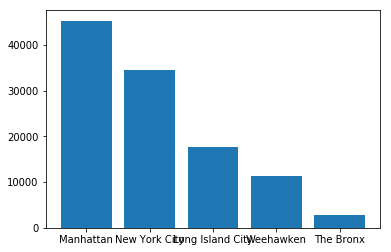

In [40]:
import collections
pcounts = collections.Counter(df.pickup_district)
pcounts.most_common()[:5]

def plot(D):
    import matplotlib.pyplot as plt
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    return plt.show()
plot(dict(pcounts.most_common()[:5]))

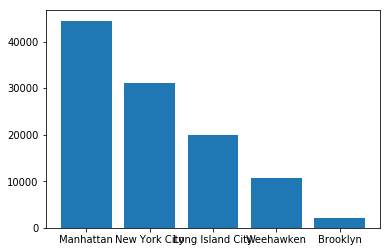

In [41]:
dcounts = collections.Counter(df.dropoff_district)
dcounts.most_common()[:5]
plot(dict(dcounts.most_common()[:5]))

Distances are calculated using geodesic distance from GeoPy package

In [42]:
from geopy.distance import geodesic
distance = []
for i in range(len(df)):
    d= geodesic( (x1[i],y1[i]),(x2[i],y2[i]))
    distance.append(d.kilometers)

df['distance'] = distance

Time of the day is little bit more complicated time intervals are calculated using a custom function

In [43]:
def dayy(t):    
    if 0 <= t.hour < 7:
        return "Late Night"
    elif 7 <= t.hour < 9:
        return "Morning Rush Hour"
    elif 9 <= t.hour < 16:
        return "Afternoon"
    elif 16 <= t.hour < 18:
        return "Evening Rush Hour"
    elif 18 <= t.hour < 23:
        return "Evening"
    else:
        return "Late Night"
a = []
for i in df.pickup_datetime:
    a.append(dayy(i))
df['timeday'] = a


Duration is calculated using datetime.datetime differences

In [44]:
diffs= (df.dropoff_datetime-df.pickup_datetime)
df['duration'] = diffs.apply(lambda x: x.total_seconds()/60.00)


Average time and average distance are calculated by first getting unique values then calculating averages

But plots uses pandas group-by then plot.bar functions.

avg distance:
Morning Rush Hour : 3.1282795086816604
Afternoon : 3.109985867593409
Late Night : 4.117634858391313
Evening Rush Hour : 3.3428142689663973
Evening : 3.378135999066236

avg duration:
Morning Rush Hour : 15.308145264610287
Afternoon : 16.0653791004227
Late Night : 14.43492428465252
Evening Rush Hour : 17.074909200968545
Evening : 14.893255479153673


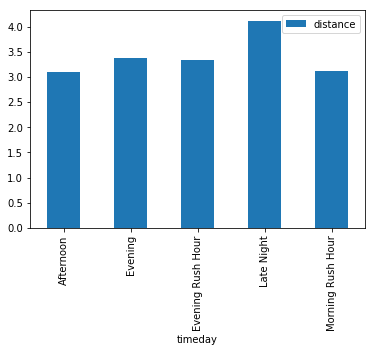

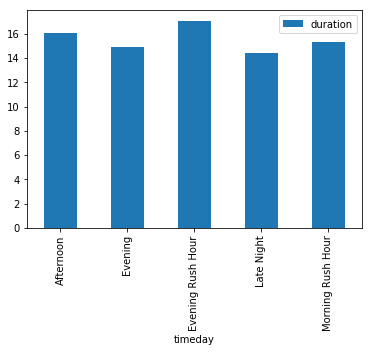

In [45]:
print('avg distance:')
for i in set(df['timeday']):
    a = df['timeday']==i
    avg_dist = df[a].distance.mean()
    print(i, ':', avg_dist)
print("")
print('avg duration:')
for i in set(df['timeday']):
    a = df['timeday']==i
    avg_t = df[a].duration.mean()
    print(i, ':', avg_t)

df[['timeday','distance']].groupby(['timeday']).mean().plot.bar()
df[['timeday','duration']].groupby(['timeday']).mean().plot.bar()


Hypothesis testing
----

This part uses T-test to check if means are compareable.

singe vs large passenger group

weekend vs weekday

In [48]:
from scipy.stats import ttest_ind

a = df.passenger_count==1
b = df.passenger_count!=1

print("single:",df[a].distance.mean(),"\n","large:",df[b].distance.mean())

t = ttest_ind(df[a].distance, df[b].distance)

if t.pvalue < 0.05:
    print ('Reject null Hypothesis')
else:
    print ('Null hypothesis cannot be rejectted!!')

single: 3.362321811059993 
 large: 3.485811202768219
Reject null Hypothesis


In [49]:
from scipy.stats import ttest_ind

a = df.pickup_datetime.apply(lambda a: a.weekday()<=4)
b = df.pickup_datetime.apply(lambda a: a.weekday()>4)


print("week:",df[a].distance.mean(),"\n","weekend:",df[b].distance.mean())

ttest = ttest_ind(df[a].distance, df[b].distance)

if t.pvalue < 0.05:
    print ('Reject null Hypothesis')
else:
    print ('Null hypothesis cannot be rejectted!!')

week: 3.357086204958974 
 weekend: 3.4954869377757602
Reject null Hypothesis
